In [1]:

import torchvision.datasets as dset 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import numpy as np
import torch
from torch.autograd import Variable   
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob


/tmp/ipykernel_319274/1431351066.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  # 添加图例


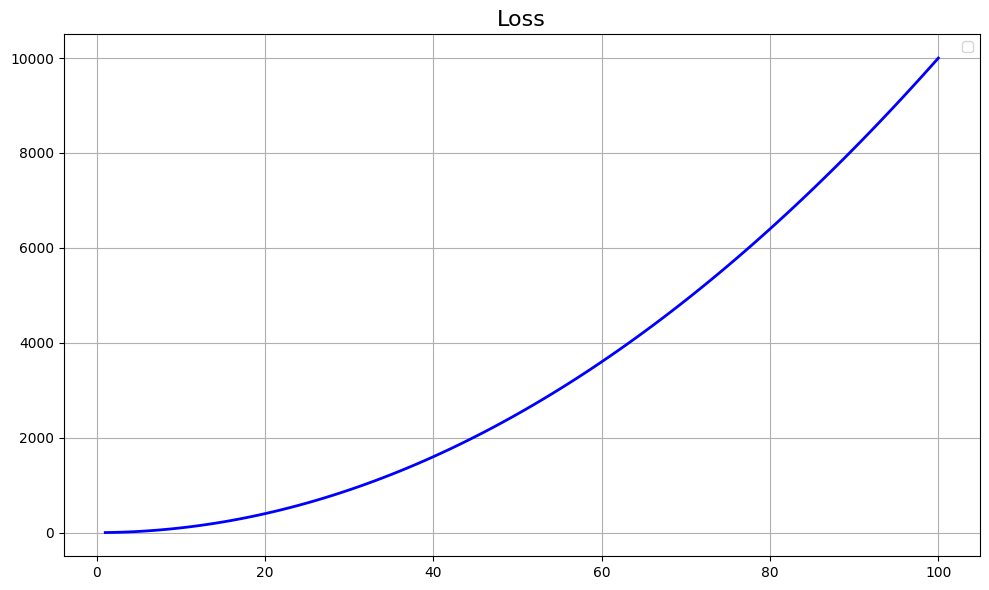

In [33]:
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

In [34]:
# # git上的示例代码，可以调用ESMC模型进行embedding
# protein = ESMProtein(sequence="AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC")
# client = ESMC.from_pretrained("esmc_600m").to("cpu") # or "cpu"
# protein_tensor = client.encode(protein)
# logits_output = client.logits(
#    protein_tensor, LogitsConfig(sequence=True, return_embeddings=True,return_hidden_states=True)
# )
# print(logits_output.hidden_states.shape)
# # 这个hidden_states就是输出的隐层特征

def ESMC_embedding(sequence:str):
   '''调用ESMC模型进行embedding
   
   输入：蛋白质序列
   输出：embedding后的隐层特征（Size = [36, 1, 68, 1152]）
   '''
   protein = ESMProtein(sequence=sequence)
   client = ESMC.from_pretrained("esmc_600m").to("cpu") # or "cpu"
   protein_tensor = client.encode(protein)
   logits_output = client.logits(protein_tensor, LogitsConfig(sequence=True, return_embeddings=True, return_hidden_states=True))
   return logits_output.hidden_states



In [35]:
# # Transformer 部分：提取全局特征
# self.transformer_encoder_layer = nn.TransformerEncoderLayer(
#     d_model=128,  # 输入特征维度
#     nhead=8,      # 多头注意力头数
#     dim_feedforward=512,  # 前馈网络隐藏层维度
#     dropout=0.1   # Dropout 概率
# )
# self.transformer_encoder = nn.TransformerEncoder(
#     self.transformer_encoder_layer, num_layers=2  # Transformer 层数
# )

In [52]:
# class SiameseNetwork(nn.Module):
#     '''
#     使用 Transformer 架构和多头注意力机制进行序列特征提取，输出特征提取后的信息。
#     '''

#     def __init__(self, embedding_dim = 1152, NormalizedSequenceLength = 50,):
#         """
#         初始化 Transformer 架构。

#         参数:
#             embedding_dim (int): 输入嵌入的维度（默认 1152）。
#         """
#         super(SiameseNetwork, self).__init__()

#         self.embedding_dim = embedding_dim
#         self.NormalizedSequenceLength = NormalizedSequenceLength


#         self.transformer_encoder_layer1 = nn.TransformerEncoderLayer(
#             d_model = self.embedding_dim,  # 输入特征维度
#             nhead=8,      # 多头注意力头数
#             dim_feedforward=512,  # 前馈网络隐藏层维度
#             dropout=0.1,  # 丢弃率
#             activation='relu'  # 激活函数
#         )

#         self.transformer_encoder1 = nn.TransformerEncoder(
#             self.transformer_encoder_layer1,  # 编码层
#             num_layers=2  # 编码层数
#         )

#         self.linear_layers1 = nn.Sequential(
#             nn.Linear(self.NormalizedSequenceLength * 36, 512),
#             nn.ReLU()
#             )
        

#         self.linear_layers2 = nn.Sequential(
#             nn.Linear(self.embedding_dim, 512),
#             nn.ReLU()
#             )
    
#         self.transformer_encoder_layer2 = nn.TransformerEncoderLayer(
#         d_model = 512,  # 输入特征维度
#         nhead=8,      # 多头注意力头数
#         dim_feedforward=512,  # 前馈网络隐藏层维度
#         dropout=0.1,  # 丢弃率
#         activation='relu'  # 激活函数
#         )

#         self.transformer_encoder2 = nn.TransformerEncoder(
#             self.transformer_encoder_layer1,  # 编码层
#             num_layers=2  # 编码层数
#         )





#     def _forward_ligand(self, x:torch.Tensor):
#         '''
#         前向传播。

#         参数:
#             x (torch.Tensor): 输入张量，形状为 [batch_size, ESMC_size, 1, sequence_length, embedding_dim]。

#         返回:
#             torch.Tensor: 输出张量，形状为 
#         '''
#         x = x.squeeze(2)  # 去掉第二维度 [batch_size, ESMC_size, sequence_length, embedding_dim]
#         x = x.reshape(x.size(0), -1, x.size(-1))  # 展平 [batch_size, ESMC_size * sequence_length, embedding_dim]
#         x = x.permute(1, 0, 2)  # 转置 [ESMC_size * sequence_length, batch_size, embedding_dim]
#         x = self.transformer_encoder1(x)  # 编码器  [ESMC_size * sequence_length, batch_size, embedding_dim] [1800, 32, 1152]
#         x = x.permute(1, 2, 0)  # 转置 [batch_size, embedding_dim, ESMC_size * sequence_length]
#         x = self.linear_layers1(x)  # 全连接层 [batch_size, embedding_dim , 512]
#         x = x.permute(2, 0, 1)  # [512, batch_size, embedding_dim]
#         x = self.transformer_encoder1(x)  # 编码器  [512, batch_size, embedding_dim]
#         x = self.linear_layers2(x) # 全连接层 [512, batch_size, 512]
#         x = self.transformer_encoder_layer2(x)  # 编码器  [512, batch_size, 512]
#         x = x.permute(1, 0, 2)   # [batch_size, 512, 512]
#         print(x.shape)

        


#         return x
    

#     def _forward_receptor(self, x:torch.Tensor):
#         '''
#         前向传播。

#         参数:
#             x (torch.Tensor): 输入张量，形状为 [batch_size, ESMC_size, 1, sequence_length, embedding_dim]。

#         返回:            
#             torch.Tensor: 输出张量，形状为
#         '''
#         x = x.squeeze(2)  # 去掉第二维度 [batch_size, ESMC_size, sequence_length, embedding_dim]
#         x = x.reshape(x.size(0), -1, x.size(-1))  # 展平 [batch_size, ESMC_size * sequence_length, embedding_dim]
#         x = x.permute(1, 0, 2)  # 转置 [ESMC_size * sequence_length, batch_size, embedding_dim]
#         x = self.transformer_encoder1(x)  # 编码器  [ESMC_size * sequence_length, batch_size, embedding_dim] [1800, 32, 1152]
#         x = x.permute(1, 2, 0)  # 转置 [batch_size, embedding_dim, ESMC_size * sequence_length]
#         x = self.linear_layers1(x)  # 全连接层 [batch_size, embedding_dim , 512]
#         x = x.permute(2, 0, 1)  # [512, batch_size, embedding_dim]
#         x = self.transformer_encoder1(x)  # 编码器  [512, batch_size, embedding_dim]
#         x = self.linear_layers2(x) # 全连接层 [512, batch_size, 512]
#         x = self.transformer_encoder_layer2(x)  # 编码器  [512, batch_size, 512]
#         x = x.permute(1, 0, 2)   # [batch_size, 512, 512]
#         print(x.shape)

#         return x


#     def forward(self, input1, input2):
#         output1 = self._forward_ligand(input1)
#         output2 = self._forward_receptor(input2)
#         return output1, output2

In [37]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label, distances = 'cosine_distance'):
        # label指示两个样本是否相似（1表示不相似，0表示相似）
        if distances == 'euclidean_distance':
            # 欧几里得距离：适合低维稠密数据，捕捉绝对差异
            euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
            loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                        (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        elif distances == 'cosine_distance':
            # 余弦距离：适合高维稀疏数据，方向敏感，适合高维稀疏矩阵
            cosine_similarity = F.cosine_similarity(output1, output2, dim=1, eps=1e-6)
            cosine_distance = 1 - cosine_similarity
            loss_contrastive = torch.mean((1-label) * torch.pow(cosine_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2))
        elif distances == 'exponential_distance':
            # 指数距离：适合需要强调微小差异的任务
            euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
            exponential_distance = torch.exp(euclidean_distance) - 1
            loss_contrastive = torch.mean((1-label) * torch.pow(exponential_distance, 2) +
                                        (label) * torch.pow(torch.clamp(self.margin - exponential_distance, min=0.0), 2))
            # 如果两个输入不相似的程度大于self.margin，即足够不相似，则loss为0，否则loss为平方距离
        else:
            raise ValueError('Unsupported distance metric: {}'.format(distances))



        return loss_contrastive

In [38]:
# 读取数据
class ProteinPairsDataset(Dataset):
    
    def __init__(self, data, NormalizedSequenceLength, Seq2Tensor_path = './Seq2Tensor', transform=None):
        """
        初始化数据集。

        参数:
            data (DataFrame): 包含序列对及其标签的 DataFrame。
            Seq2Tensor_path (str): 存储张量数据的路径。
        """
        self.data = data  
        self.NormalizedSequenceLength = NormalizedSequenceLength
        self.Seq2Tensor_path = Seq2Tensor_path
        self.ProteinPairsDataTensors = set([path.split('/')[-1].rsplit('.', 1)[0] for path in glob.glob(f"{Seq2Tensor_path}/*pt")]) # 加载已经保存好的Emdeding数据
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def seq2tensor(self, seq):
        if seq in self.ProteinPairsDataTensors:
            return torch.load(f"{self.Seq2Tensor_path}/{seq}.pt")
        else:
            seq_tensor = ESMC_embedding(seq)
            try:
                torch.save(seq_tensor, f"{self.Seq2Tensor_path}/{seq}.pt")
            except:
                print(f"Error: {seq} cannot be saved.")
            self.ProteinPairsDataTensors.add(seq)
            return seq_tensor
    
    
    def __len__(self):
        """返回数据集的大小"""
        return len(self.data)
        
    def __getitem__(self, idx):
        """
        获取特定索引的样本。

        参数:
            idx (int): 索引值

        返回:
            dict: 包含序列对及其标签的字典
        """
        sequence1 = self.data.iloc[idx]['sequence1']  # 根据列名获取序列1
        sequence2 = self.data.iloc[idx]['sequence2']  # 根据列名获取序列2
        label = self.data.iloc[idx]['label']  # 根据列名获取标签

        # 将序列转成张量，使用seq2tensor
        sequence1_tensor = self.seq2tensor(sequence1)
        sequence2_tensor = self.seq2tensor(sequence2)

        if self.transform is not None:
            sequence1_tensor = self.transform(sequence1_tensor, self.NormalizedSequenceLength)
            sequence2_tensor = self.transform(sequence2_tensor, self.NormalizedSequenceLength)        

        return {"sequence1": sequence1_tensor, "sequence2": sequence2_tensor, "label": label}

def transform(sequence_tensor, NormalizedSequenceLength = 50):
    """
    判断序列张量是否合规，否则进行变换
    """
    # 输入的形状为[ESM_size, 1, sequence_length, embedding_dim]
    # 输出的形状为[ESM_size, 1, NormalizedSequenceLength, embedding_dim]
    if sequence_tensor.shape[2] > NormalizedSequenceLength:
        sequence_tensor = sequence_tensor[:, :, :NormalizedSequenceLength, :]
    elif sequence_tensor.shape[2] < NormalizedSequenceLength:
        padding_tensor = torch.zeros(sequence_tensor.shape[0], sequence_tensor.shape[1], NormalizedSequenceLength - sequence_tensor.shape[2], sequence_tensor.shape[3])
        sequence_tensor = torch.cat((sequence_tensor, padding_tensor), dim=2)
    return sequence_tensor



# 加载数据
def load_data(ProteinPairsData_csv_path, Seq2Tensor_path, NormalizedSequenceLength =50, batch_size=32, val_size=0.1, test_size=0.1):
    """
    加载数据并划分为训练集、验证集和测试集。

    参数:
        ProteinPairsData_csv_path (str): CSV 文件路径。
        batch_size (int): 每个批次的大小。
        val_size (float): 验证集的比例（0-1之间的浮点数）。
        test_size (float): 测试集的比例（0-1之间的浮点数）。

    返回:
        tuple: 训练集, 验证集和测试集的 DataLoader。
    """
    # 读取 CSV 文件
    data = pd.read_csv(ProteinPairsData_csv_path)

    # 划分训练集和临时集（临时集中将会包含验证集和测试集）
    train_data, temp_data = train_test_split(data, test_size=(val_size + test_size), random_state=42)

    # 计算临时集中验证集和测试集的比例
    temp_val_size = val_size / (val_size + test_size)
    
    # 划分验证集和测试集
    val_data, test_data = train_test_split(temp_data, test_size=temp_val_size, random_state=42)

    # 创建数据集实例
    train_dataset = ProteinPairsDataset(data = train_data,
                                        NormalizedSequenceLength = NormalizedSequenceLength,
                                        Seq2Tensor_path = Seq2Tensor_path,
                                        transform = transform)
    val_dataset = ProteinPairsDataset(data = val_data,
                                      NormalizedSequenceLength = NormalizedSequenceLength,
                                      Seq2Tensor_path = Seq2Tensor_path,
                                      transform = transform)
    test_dataset = ProteinPairsDataset(data = test_data,
                                       NormalizedSequenceLength = NormalizedSequenceLength,
                                       Seq2Tensor_path = Seq2Tensor_path,
                                       transform = transform)

    # 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader







In [39]:
# csv_file_path = "/home/users/hcdai/AI-peptide/Seq2Score/SiameseNetWork/est.csv"
# train_loader, val_loader, test_loader = load_data(csv_file_path,batch_size=1)
# # 迭代训练集
# for batch in train_loader:
#     # print(batch["sequence1"], batch["sequence2"], batch["label"])
#     print(batch["sequence1"].shape, batch["sequence2"].shape, batch["label"].shape)

# # 迭代验证集
# for batch in val_loader:
#     print(batch["sequence1"], batch["sequence2"], batch["label"])

# # 迭代测试集
# for batch in test_loader:
#     print(batch["sequence1"], batch["sequence2"], batch["label"])

In [40]:
# 基础准备
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss,label):
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(iteration, loss, color='blue', linewidth=2)  # 绘制损失曲线
    plt.title(label, fontsize=16)  # 设置标题
    plt.legend()  # 添加图例
    plt.grid(True)  # 显示网格
    plt.tight_layout()  # 自适应布局
    plt.show()  # 显示图表

# # 测试
# iteration = range(1, 101)
# loss = [i**2 for i in iteration]
# label = 'Loss of Siamese Network'
# show_plot(iteration, loss, label)


In [41]:
def save_model(model, optimizer, epoch, file_path):
    """
    保存模型及其状态

    参数:
        model: 要保存的模型
        optimizer: 优化器
        epoch: 当前训练的epoch
        file_path: 保存的文件路径
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, file_path)

def load_model(model, optimizer, file_path):
    """
    加载模型及其状态

    参数:
        model: 要加载的模型
        optimizer: 优化器
        file_path: 加载的文件路径
    """
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']  # 返回加载的epoch

In [42]:
# 定义训练循环

def train_model(model, train_loader, val_loader, num_epochs, learning_rate, margin, model_save_path=None):
    """
    训练模型

    参数:
        model: 要训练的模型
        train_loader: 用于训练的数据加载器
        val_loader: 用于验证的数据加载器
        num_epochs: 训练的轮数
        learning_rate: 学习率
        margin: 正负样本的margin值，用于loss计算
    """
    # 设置优化器
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = ContrastiveLoss(margin=margin)  # 定义对比损失类

    train_losses = []  # 用于记录训练损失
    val_losses = []    # 用于记录验证损失

    # 训练模型
    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        train_loss = 0.0
        
        # for batch in train_loader:
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'): # 使用 tqdm 包装 train_loader，显示进度
            sequence1 = batch["sequence1"]
            sequence2 = batch["sequence2"]
            labels = batch["label"]

            optimizer.zero_grad()  # 清零梯度
            
            # 前向传播
            output1, output2 = model(sequence1, sequence2)

            # 计算损失
            loss = criterion(output1, output2, labels)
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
            
            train_loss += loss.item()

        # 验证
        avg_train_loss = train_loss / len(train_loader)
        val_loss = validate_model(model, val_loader, criterion)

        # 记录损失
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # 每个epoch后保存模型
        if model_save_path:
            save_model(model, optimizer, epoch, model_save_path)  # 每个epoch后保存模型

        # # 可视化部分
        # # 绘制损失曲线
        # plt.figure()
        # show_plot(range(num_epochs), train_losses, label='Training Loss')
        # show_plot(range(num_epochs), val_losses, label='Validation Loss')

    

def validate_model(model, val_loader, criterion):
    """
    验证模型

    参数:
        model: 要验证的模型
        val_loader: 用于验证的数据加载器
        criterion: 损失函数
    """
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0

    with torch.no_grad():  # 评估时不需要反向传播
        for batch in val_loader:
            sequence1 = batch["sequence1"]
            sequence2 = batch["sequence2"]
            labels = batch["label"]

            # 前向传播
            output1, output2 = model(sequence1, sequence2)

            # 计算损失
            loss = criterion(output1, output2, labels)
            val_loss += loss.item()

    return val_loss / len(val_loader)

# def test_model(model, test_loader):
#     """
#     测试模型并计算测试损失和准确率。

#     参数:
#         model: 要测试的模型
#         test_loader: 用于测试的数据加载器
#         criterion: 损失函数

#     返回:
#         float: 测试损失
#         float: 测试准确率
#     """
#     model.eval()  # 设置模型为评估模式
#     criterion = ContrastiveLoss()
#     test_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad():  # 评估时不需要反向传播
#         for batch in test_loader:
#             sequence1 = batch["sequence1"]
#             sequence2 = batch["sequence2"]
#             labels = batch["label"]

#             # 前向传播
#             output1, output2 = model(sequence1, sequence2)
            
#             # 计算损失
#             loss = criterion(output1, output2, labels)
#             test_loss += loss.item()

#             # 计算准确率，这里假设通过某种方式获取每个样本的预测结果
#             # 需要定义一个方法计算预测结果，比如使用阈值来决定正负样本
#             predicted = (torch.nn.functional.cosine_similarity(output1, output2) > 0.5).float()  # 示例
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     avg_test_loss = test_loss / len(test_loader)
#     accuracy = correct / total * 100  # 转换为百分比

#     print(f'Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')
#     return avg_test_loss, accuracy

In [43]:
   
# ProteinPairsData_csv_path = "/home/users/hcdai/AI-peptide/Seq2Score/SiameseNetWork/est.csv",
# train_batch_size = 64,
# train_number_epochs = 100,
# learning_rate = 0.001, # learning_rate (float): SiameseNetwork的学习率
# distances = "cosine_distance", # distances (str): 距离函数，可选["cosine_distance", "euclidean_distance", "exponential_distance"]
# margin = 2.0 # margin (float): 正负样本的margin值，用于loss计算
# val_size = 0.1 # val_size (float): 验证集的比例（0-1之间的浮点数）
# test_size = 0.1 # test_size (float): 测试集的比例（0-1之间的浮点数）

In [44]:
# 加载config文件
config_json_path = '/home/users/hcdai/AI-peptide/Seq2Score/SiameseNetWork/SNW_config.json'
with open(config_json_path, 'r') as f:
    SNW_Config = json.load(f)

# 加载数据
train_loader, val_loader, test_loader = load_data(ProteinPairsData_csv_path = SNW_Config["ProteinPairsData_csv_path"], 
                                                  Seq2Tensor_path=SNW_Config["Seq2Tensor_path"], 
                                                  NormalizedSequenceLength = SNW_Config["NormalizedSequenceLength"], 
                                                  batch_size=32, 
                                                  val_size=0.1, 
                                                  test_size=0.1)

# 实例化模型
model = SiameseNetwork()

# 初始化优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 指定保存路径
model_save_path = 'model_checkpoint.pth'

# 加载已保存的模型
# load_model(model, optimizer, model_save_path)

# 训练模型
train_model(model = model, 
            train_loader = train_loader, 
            val_loader = val_loader, 
            num_epochs = SNW_Config["train_number_epochs"], 
            learning_rate = SNW_Config['learning_rate'], 
            margin = SNW_Config['margin'],
            model_save_path = model_save_path)

# # 测试模型
# try:
#     load_model(model, optimizer, model_load_path = model_save_path)
# except FileNotFoundError:
#     print('没有找到模型，要进行测试时，请确保模型文件存在。')

# # 测试模型
# test_model(model, test_loader)

/home/users/hcdai/miniconda3/envs/ESMC/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1/100:   0%|          | 0/18 [00:00<?, ?batch/s]/tmp/ipykernel_266480/2243212197.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly a

RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 3317760000 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
class Unet(nn.Module):
    """很经典的Unet网络"""

    def __init__(self, input_nbr, label_nbr):
        super(Unet, self).__init__()

        self.conv11 = nn.Conv2d(2*input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)


        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)

        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x))))
        x12 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43, kernel_size=2, stride=2)


        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43.size(3) - x4d.size(3), 0, x43.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33.size(3) - x3d.size(3), 0, x33.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22.size(3) - x2d.size(3), 0, x22.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12.size(3) - x1d.size(3), 0, x12.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        output = []
        output.append(x11d)

        return output